# Packages

In [4]:
import plotly.express as px
import pandas as pd
from google.cloud import bigquery
import numpy as np
from datetime import time, timedelta, datetime
import math 
import plotly.graph_objects as go
import warnings
warnings.filterwarnings('ignore')
import scipy.stats as st
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display_html
import os
import ipywidgets
import statsmodels.stats.weightstats as sw
from statsmodels.stats.proportion import test_proportions_2indep
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
from google.cloud import bigquery
from scipy.stats import norm
from scipy import stats
pd.options.display.float_format = "{:,.2f}".format
from scipy.stats import norm
from scipy import stats
import statsmodels.stats.weightstats as ws
import openpyxl
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')
# from ambrosia.designer import Designer, design, load_from_config

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima_process import ArmaProcess
from scipy.signal.windows import gaussian
from causalimpact import CausalImpact
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
import statsmodels.api as sm
from scipy.stats import ttest_1samp
from tqdm.notebook import tqdm

# df["Week"] = df["Date"].dt.to_period("W").dt.to_timestamp()

bigquery_client = bigquery.Client(project='analytics-dev-333113')

def cycle_sql(start, end, query, weeks=False):
    """
    You have to use {day} in your script to add cycle date into this backets
    """
    date_start = datetime.strptime(start, '%Y-%m-%d')
    date_end = datetime.strptime(end, '%Y-%m-%d')

    if weeks == False:
        daterange = [(date_start + timedelta(days=x)).strftime('%Y-%m-%d') for x in range(((date_end-date_start).days)+1)]
    else:
        daterange = [(date_start + timedelta(weeks=x)).strftime('%Y-%m-%d') for x in range(((date_end-date_start).days//7)+1)] # weeks dividing days by 7

    total_df = pd.DataFrame()

    for date in daterange:
        print(f"Uploading - {date}:", datetime.today().strftime('%Y-%m-%d %H:%M:%S'))
        script = query.format(date = date)
        df_cycle = bigquery_client.query(script).to_dataframe()
        if df_cycle.empty == True:
            print('Dataframe is empty')
        total_df = pd.concat([df_cycle, total_df])
    return total_df

def read_bq(query, project='analytics-dev-333113'):
    client = bigquery.Client(project=project)
    query_job = client.query(query)
    result_df = query_job.to_dataframe()
    return result_df

def writing_excel(name:str, dataset1=None, dataset2=None, dataset3=None, dataset4=None):
    with pd.ExcelWriter(f"{name}.xlsx") as writer:
   
    # use to_excel function and specify the sheet_name and index 
    # to store the dataframe in specified sheet

        if dataset1 is not None:
            if dataset2 is not None:
                if dataset3 is not None:
                    if dataset4 is not None:
                        dataset1.to_excel(writer, sheet_name=f"1-{name}", 
                                        #   index=False
                                          )
                        dataset2.to_excel(writer, sheet_name=f"2-{name}", 
                                        #   index=False
                                          )
                        dataset3.to_excel(writer, sheet_name=f"3-{name}", 
                                        #   index=False
                                          )
                        dataset4.to_excel(writer, sheet_name=f"4-{name}", 
                                        #   index=False
                                          )
                    else:
                        dataset1.to_excel(writer, sheet_name=f"1-{name}", 
                                        #   index=False
                                          )
                        dataset2.to_excel(writer, sheet_name=f"2-{name}", 
                                        #   index=False
                                          )
                        dataset3.to_excel(writer, sheet_name=f"3-{name}", 
                                        #   index=False
                                          )
                else:
                    dataset1.to_excel(writer, sheet_name=f"1-{name}", 
                                    #   index=False
                                      )
                    dataset2.to_excel(writer, sheet_name=f"2-{name}", 
                                    #   index=False
                                      )
            else:
                dataset1.to_excel(writer, sheet_name=f"1-{name}", 
                                #   index=False
                                  )

        print('DataFrame is written to Excel File successfully.')

def get_minimal_determinable_effect(std, sample_size, alpha, beta):
    t_alpha = norm.ppf(1 - alpha / 2, loc=0, scale=1)
    t_beta = norm.ppf(1 - beta, loc=0, scale=1)
    disp_sum_sqrt = (2 * (std ** 2)) ** 0.5
    mde = (t_alpha + t_beta) * disp_sum_sqrt / np.sqrt(sample_size)
    return mde

def get_sample_size_abs(epsilon, std, alpha, beta):
    t_alpha = norm.ppf(1 - alpha / 2, loc=0, scale=1)
    t_beta = norm.ppf(1 - beta, loc=0, scale=1)
    z_scores_sum_squared = (t_alpha + t_beta) ** 2
    sample_size = int(
        np.ceil(
            z_scores_sum_squared * (2 * std ** 2) / (epsilon ** 2)
        )
    )
    return sample_size

def get_ttest_pvalue(metrics_a_group, metrics_b_group):
    _, pvalue = stats.ttest_ind(metrics_a_group, metrics_b_group)
    return pvalue

def estimate_errors(group_generator, effect_add_type, effect, alpha):
    pvalues_aa = []
    pvalues_ab = []
    for a_metric_values, b_metric_values in group_generator:
        pvalues_aa.append(get_ttest_pvalue(a_metric_values, b_metric_values))
        b_metric_values_with_effect = b_metric_values.copy()
        if effect_add_type == 'all_percent':
            b_metric_values_with_effect *= 1 + effect / 100
        elif effect_add_type == 'all_const':
            b_metric_values_with_effect += b_metric_values_with_effect.mean() * effect / 100
        pvalues_ab.append(get_ttest_pvalue(a_metric_values, b_metric_values_with_effect))
    first_type_error = np.mean(np.array(pvalues_aa) < alpha)
    second_type_error = np.mean(np.array(pvalues_ab) >= alpha)
    return pvalues_aa, pvalues_ab, first_type_error, second_type_error





# Calculations before experiment

In [ ]:
# How many users are going to be affected on through PHC trigger system (In fact, all users with more than 1 device that's detected by us)

df_impact = read_bq("""
WITH rides AS (SELECT t1.city_id,
                      t2.city_name,
                      metric_date_utc,
                      SUM(rides_count) AS rides
               FROM indriver-bi.incity.tbl_incity_growth_metrics_detail t1
                        JOIN `indriver-bi.heap.vw_macroregion_mapping` t2
                             ON t1.city_id = t2.city_id
               WHERE metric_date_utc = '2024-10-01'
                 AND user_type = 'driver'
                 AND t1.country_id IN (11, 25, 12, 24, 22, 10, 40, 75, 76, 77)
               GROUP BY 1, 2, 3),
     incidents AS (SELECT redmine_id,
                          incident_date,
                          vertical,
                          aggressor,
                          incident_type,
                          category,
                          city_id,
                          city_name,
                          pass_id,
                          driver_id
                   FROM indriver-bi.safety.vw_safety_incidents_detail
                   WHERE aggressor = 'Driver'
                     AND incident_date >= '2024-10-01'
                     AND information_status = 'Confirmed'),
     change_device AS (SELECT user_id, city_id, session_dt_part, COUNT(shield_id) AS cnt_devices
                       FROM (SELECT DISTINCT fl.user_id, fl.city_id, session_dt_part, shield_id
                             FROM indriver-e6e40.antifraud.fingerprint_log fl
                                      JOIN indriver-e6e40.antifraud.shield_fingerprints sf USING (fingerprint_id)
                             WHERE event_dt_part = '2024-10-01'
                               AND session_dt_part = '2024-10-01'
                               AND shield_id != 'NOT_FOUND'
                               AND fl.user_id IS NOT NULL
                               AND fl.country_id IN (11, 25, 12, 24, 22, 10, 40, 75, 76, 77)
                             QUALIFY ROW_NUMBER() OVER (PARTITION BY fl.user_id, shield_id ORDER BY sf.timestamp) = 1)
                       GROUP BY 1, 2, 3)
SELECT t1.user_id,
       t1.city_id,
       loc.name,
       t1.session_dt_part,
       t1.cnt_devices,
       t3.rides,
       t2.redmine_id,
       t2.incident_date,
       t2.driver_id
FROM change_device t1
         JOIN indriver-e6e40.ods_monolith.tbl_city loc
              ON t1.city_id = loc.id
         LEFT JOIN incidents t2
                   ON t1.user_id = t2.driver_id
                       AND t2.incident_date >= session_dt_part
         LEFT JOIN rides t3
                   ON t1.city_id = t3.city_id
                       AND t1.session_dt_part = t3.metric_date_utc
WHERE t1.city_id IN (4300,4349,4299,5547,5543,5535,4255,4252,4196,4545,4376,4540)
""")

df_impact.head()

In [ ]:
df_impact_agg = df_impact.query("cnt_devices > 1").groupby(['name', 'session_dt_part'], as_index=False)[['user_id', 'redmine_id', 'rides']] \
                        .agg({'user_id':'nunique',
                            'redmine_id':'count',
                            'rides':'max'})

df_impact_agg['share_of_users'] = df_impact_agg['user_id'] / df_impact_agg['rides'] * 100

df_impact_agg['IR'] = df_impact_agg['redmine_id'] / df_impact_agg['rides'] * 100000

df_impact_agg

# Matching process

### Choosing the cities

In [ ]:
df_matching_city = read_bq("""
WITH city AS (SELECT DISTINCT city_id,
                              city_name,
                              country_id,
                              country_name
              FROM indriver-e6e40.heap.vw_macroregion_mapping
              WHERE country_id IN (22, 11, 24, 12, 10))

SELECT t1.city_id,
       city.city_name,
       city.country_name,
       IF(t1.city_id IN (4300, 4349, 4299, 5547, 5543, 5535, 4255, 4252, 4196, 4545, 4376, 4540), 1,
          0) AS                                          segment,
       SUM(rides_count)                                  rides_count,
       SUM(orders_count)                                 orders_count,
       SUM(tenders_count)                                tenders_count,
       SUM(bid_count)                                    bid_count,
       SUM(rides_count_from_feed)                        rides_count_from_feed,
       SUM(rides_count_from_sn)                          rides_count_from_sn,
       SUM(gmv_clean_usd)                                gmv,
       SUM(orders_with_driver_arrived_late_count)        orders_with_driver_arrived_late_count,
       SUM(orders_with_driver_arrived_early_count)       orders_with_driver_arrived_early_count,
       SUM(pass_with_third_ride_count)                   pass_with_third_ride_count,
       SUM(rides_count_from_autobid)                     rides_count_from_autobid,
       AVG(ETA_sum)                                      avg_eta,
       AVG(RTA_sum)                                      avg_rta,
       SUM(reorders_count)                               reorders_count,
       SUM(canceled_arrived_orders_count)                canceled_arrived_orders_count,
       SUM(canceled_started_orders_count)                canceled_started_orders_count,
       SAFE_DIVIDE(SUM(gmv_clean_usd), SUM(rides_count)) avg_ride_price
FROM indriver-bi.incity.tbl_incity_growth_metrics_detail t1
         JOIN city
              ON t1.city_id = city.city_id
WHERE 1 = 1
  AND user_type = 'pass'
  AND metric_date_utc BETWEEN '2024-09-01'
    AND '2024-11-30'
GROUP BY 1, 2, 3, 4
""")

In [ ]:
import numpy as np

def euclidean_distance(metrics1, metrics2):
    return np.round(np.sqrt(np.sum((np.array(metrics1) - np.array(metrics2)) ** 2)), 2)

iterations = 1000
set_distance = 99999999

for i in tqdm(range(iterations)):
    control = pd.DataFrame(df_matching_city['city_name'].sample(round(len(df_matching_city)/2), replace=False))
    test = pd.merge(df_matching_city, control, on=['city_name'], how="outer", indicator=True)
    test = test[test['_merge']=='left_only']
    test = test[['city_name']]
    
    control_data = df_matching_city[df_matching_city['city_name'].isin(control['city_name'])]
    test_data = df_matching_city[df_matching_city['city_name'].isin(test['city_name'])]

    vector1=[]
    vector2=[]
    for feature in list(df_matching_city.drop(['city_name'], axis=1)):
        vector1.append(control_data[feature].mean())
        vector2.append(test_data[feature].mean())
    
    euclid_distance = euclidean_distance(vector1, vector2)
    
    if euclid_distance < set_distance:
        set_distance = euclid_distance
        control_final = control_data.copy()
        test_final = test_data.copy()


### Choosing the users

In [ ]:
df_matching_user = read_bq("""
WITH personal AS (SELECT id AS                                                          user_id,
                         MAX(IF(created IS NOT NULL, DATE_DIFF(CURRENT_DATE(), DATE(created), MONTH),
                                0))                                                     age_registration,
                         COALESCE(MAX(rating3), 5)                                      rating,
                         MAX(country_id)                                                country_id,
                         MAX(IF(avatarmedium IS NOT NULL AND avatarmedium != '', 1, 0)) avatar_flag,
                         MAX(IF(banned IS NULL, 0, 1))                                  bans_flag
                  FROM dwh-storage-327422.personal_data.tbl_user_act
                  WHERE 1 = 1
                    AND mode = 'client'
                    AND city_id IN (4300, 4349, 4299, 5547, 5543, 5535, 4255, 4252, 4196, 4545, 4376, 4540)
                  GROUP BY 1),
     triggered_users AS (SELECT DISTINCT t1.user_id
                         FROM indriver-e6e40.ods_banhammer.user_log_global t1
                         WHERE t1.created_at >= '2024-11-13'
                           AND t1.config_id IN (10521, 10522, 10523, 10524, 10561, 10562, 10563, 10560)),
     rides AS (SELECT user_id,
                      IF(t1.city_id IN
                         (4300, 4349, 4299, 5547, 5543, 5535, 4255, 4252, 4196, 4545, 4376, 4540), 1,
                         0)                                       has_treatment,
                      SUM(rides_count)                            rides_count,
                      SUM(orders_count)                           orders_count,
                      SUM(tenders_count)                          tenders_count,
                      SUM(bid_count)                              bid_count,
                      SUM(rides_count_from_feed)                  rides_count_from_feed,
                      SUM(rides_count_from_sn)                    rides_count_from_sn,
                      SUM(gmv_clean_usd)                          gmv,
                      SUM(orders_with_driver_arrived_late_count)  orders_with_driver_arrived_late_count,
                      SUM(orders_with_driver_arrived_early_count) orders_with_driver_arrived_early_count,
                      SUM(pass_with_third_ride_count)             pass_with_third_ride_count,
                      SUM(rides_count_from_autobid)               rides_count_from_autobid,
                      AVG(ETA_sum)                                avg_eta,
                      AVG(RTA_sum)                                avg_rta,
                      SUM(reorders_count)                         reorders_count,
                      SUM(canceled_arrived_orders_count)          canceled_arrived_orders_count,
                      SUM(canceled_started_orders_count)          canceled_started_orders_count,
                      SUM(gmv_clean_usd) / SUM(rides_count)       avg_ride_price
               FROM indriver-bi.incity.tbl_incity_growth_metrics_detail t1
               WHERE 1 = 1
                 AND user_type = 'pass'
                 AND metric_date_utc BETWEEN '2024-08-01' AND '2024-11-30'
                 AND city_id IN (4300, 4349, 4299, 5547, 5543, 5535, 4255, 4252, 4196, 4545, 4376, 4540)
               GROUP BY 1, 2
               HAVING rides_count >= 1)

SELECT p.*,
       r.* EXCEPT (user_id)
FROM rides r
         JOIN personal p ON r.user_id = p.user_id
""")

In [ ]:
from hypex.utils.tutorial_data_creation import create_test_data

df = create_test_data(num_users=10000, rs=42, na_step=45, nan_cols=['age', 'gender'])
df

info_col = ['user_id']

outcome = 'post_spends'
treatment = 'treat'

# Standard model with base parameters
model = Matcher(input_data=df, outcome=outcome, treatment=treatment, info_col=info_col,
                algo='fast')

selected_features = model.feature_select()
selected_features

In [ ]:
results, quality_results, df_matched = model.estimate(features=chosen_features)


In [ ]:
results


In [ ]:
quality_results


In [ ]:
df_matched


# Experiment design in certain cities

### MDE, Sample size, Period for each city

In [54]:
# Avg number of rides by driver and Incidents 

df_rides = read_bq("""
WITH rides AS (SELECT user_id,
                      user_type,
                      t1.country_id,
                      t2.country_name,
                      t1.city_id,
                      t2.city_name,
                      SUM(rides_count)                AS rides_counts,
                      ROUND(SUM(rides_count) / 30, 2) AS avg_by_driver
               FROM indriver-bi.incity.tbl_incity_growth_metrics_detail t1
                        JOIN indriver-bi.heap.vw_macroregion_mapping t2
                             ON t1.city_id = t2.city_id
               WHERE metric_date_utc BETWEEN DATE_ADD(CURRENT_DATE()
                   , INTERVAL - 31 DAY)
                   AND DATE_ADD(CURRENT_DATE()
                       , INTERVAL - 1 DAY)
                 AND user_type = 'driver'
               GROUP BY 1, 2, 3, 4, 5, 6),
     incidents AS (SELECT incident_date
                        , redmine_id
                        , driver_id
                        , city_id
                        , city_name
                        , category
                   FROM (SELECT redmine_id
                              , incident_date
                              , vertical
                              , aggressor
                              , incident_type
                              , category
                              , city_id
                              , city_name
                              , pass_id
                              , driver_id
                         FROM indriver-bi.safety.vw_safety_incidents_detail
                         WHERE aggressor = 'Driver'
                           AND incident_date BETWEEN DATE_ADD(CURRENT_DATE(), INTERVAL - 31 DAY) AND DATE_ADD(CURRENT_DATE(), INTERVAL - 1 DAY)
                           AND information_status = 'Confirmed'))
SELECT t1.*,
       IF(t2.redmine_id IS NOT NULL, 1, 0) AS has_incident
FROM rides t1
         LEFT JOIN incidents t2
                   ON t1.user_id = t2.driver_id
""")

# Users who completed the avatar flow and made a first ride after that
df_cr_approved_ride = read_bq("""
WITH phc AS (SELECT t1.id,
                    check_uuid,
                    user_id,
                    t1.city_id,
                    t2.city_name,
                    t2.country_id,
                    t2.country_name,
                    status,
                    type,
                    created,
                    event,
                    modified,
                    event_by,
                    created_date_part,
                    photo_uploaded,
                    banner_date,
                    source,
                    check_date
             FROM dwh-storage-327422.photocontrol.events t1
                      JOIN `indriver-bi.heap.vw_macroregion_mapping` t2
                           ON t1.city_id = t2.city_id
             WHERE 1 = 1
               AND t1.created_date_part BETWEEN '2024-09-01' AND (CURRENT_DATE() - INTERVAL 1 DAY)
               AND t1.created_date_part NOT IN ('2024-10-09')
               AND t1.type IN ("TYPE_AVATAR")
               AND t1.source = 'facechecker'
             QUALIFY ROW_NUMBER() OVER (PARTITION BY user_id, type, created_date_part ORDER BY modified DESC) = 1),
     rides AS (SELECT order_uuid,
                      driver_id,
                      city_id,
                      country_id,
                      status_order,
                      order_timestamp,
                      driverdone_timestamp,
                      driverstarttheride_timestamp,
                      created_date_order_part
               FROM indriver-e6e40.imart.incity_detail_new_order
               WHERE created_date_order_part >= '2024-09-01')
SELECT user_id,
       t1.city_id,
       t1.city_name,
       t1.country_id,
       country_name,
       MAX(IF((event = "EVENT_APPROVED"), 1, 0))                              AS total_approved,
       MAX(IF((event = "EVENT_APPROVED" AND event_by = "EVENT_BY_ML"), 1, 0)) AS approved_by_ml_flg,
       MAX(IF((driverstarttheride_timestamp IS NOT NULL), 1, 0))              AS start_ride_flg,
FROM phc t1
         LEFT JOIN rides t2
                   ON t1.user_id = t2.driver_id
                       AND t2.driverstarttheride_timestamp BETWEEN t1.modified AND (t1.modified + INTERVAL 7 DAY)
GROUP BY 1, 2, 3, 4, 5
""")

# How many users change their devices within day
df_sample_size = read_bq("""
WITH drivers AS (SELECT id,
                        mode,
                        created,
                        country_id,
                        city_id
                 FROM indriver-e6e40.ods_monolith.tbl_user
                 WHERE mode = 'driver'),
     change_device AS (SELECT user_id, city_id, session_dt_part, COUNT(shield_id) AS cnt_devices
                       FROM (SELECT DISTINCT fl.user_id, fl.city_id, session_dt_part, shield_id
                             FROM indriver-e6e40.antifraud.fingerprint_log fl
                                      JOIN indriver-e6e40.antifraud.shield_fingerprints sf USING (fingerprint_id)
                             WHERE event_dt_part = '2024-10-01'
                               AND session_dt_part = '2024-10-01'
                               AND shield_id != 'NOT_FOUND'
                               AND fl.user_id IS NOT NULL
                               AND fl.country_id IN (11, 25, 12, 24, 22, 10, 40, 75, 76, 77)
                             QUALIFY ROW_NUMBER() OVER (PARTITION BY fl.user_id, shield_id ORDER BY sf.timestamp) = 1)
                       GROUP BY 1, 2, 3
                       HAVING COUNT(shield_id) > 1)
SELECT session_dt_part,
       loc.country_id,
       loc.country_name,
       t1.city_id,
       loc.city_name,
       COUNT(DISTINCT user_id) AS users_with_device_changing
FROM change_device t1
         JOIN indriver-e6e40.heap.vw_macroregion_mapping loc
              ON t1.city_id = loc.city_id
         JOIN drivers t2
              ON t1.user_id = t2.id
WHERE t1.city_id IN (4300, 4349, 4299, 5547, 5543, 5535, 4255, 4252, 4196, 4545, 4376, 4540)
GROUP BY 1, 2, 3, 4, 5
""")


# Chosen cities: (4300, 4349, 4299, 5547, 5543, 5535, 4255, 4252, 4196, 4545, 4376, 4540)


In [56]:
# Choosing the particular cities that participate in experiment

df_rides = df_rides.query("city_id in (4300, 4349, 4299, 5547, 5543, 5535, 4255, 4252, 4196, 4545, 4376, 4540)")
df_cr_approved_ride = df_cr_approved_ride.query("city_id in (4300, 4349, 4299, 5547, 5543, 5535, 4255, 4252, 4196, 4545, 4376, 4540)")

In [76]:
one_day_traffic = int(df_sample_size.groupby('session_dt_part', as_index =False)['users_with_device_changing'].sum()['users_with_device_changing'])
week_traffic = one_day_traffic * 7
two_week_traffic = one_day_traffic * 14
three_week_traffic = one_day_traffic * 21
month_traffic = one_day_traffic * 30

In [111]:
### Set parameters grid
effects = [1.01, 1.02, 1.03, 1.04, 1.05]  # MDE in percents
sizes = [week_traffic, two_week_traffic, three_week_traffic, month_traffic]  # Size of each group
first_type_errors = [0.01, 0.05]
second_type_errors = [0.2]

designer_target = Designer(dataframe=df_cr_approved_ride, metrics='start_ride_flg')
designer_guardrail1 = Designer(dataframe=df_cr_approved_ride, metrics='total_approved')
designer_guardrail2 = Designer(dataframe=df_rides, metrics='rides_counts')
designer_guardrail3= Designer(dataframe=df_rides, metrics='has_incident')

designer_target.set_first_errors(first_type_errors)
designer_target.set_second_errors(second_type_errors)
designer_guardrail1.set_first_errors(first_type_errors)
designer_guardrail1.set_second_errors(second_type_errors)
designer_guardrail2.set_first_errors(first_type_errors)
designer_guardrail2.set_second_errors(second_type_errors)
designer_guardrail3.set_first_errors(first_type_errors)
designer_guardrail3.set_second_errors(second_type_errors)

target = designer_target.run(to_design='effect',
             method='theory',
             first_type_errors=first_type_errors,
             second_type_errors=second_type_errors,
             sizes=sizes)
target['Metric'] = 'CR to first ride upon check (Target)'

guard1 = designer_guardrail1.run(to_design='effect',
             method='theory',
             first_type_errors=first_type_errors,
             second_type_errors=second_type_errors,
             sizes=sizes)
guard1['Metric'] = 'CR to status approved (Guardrail)'

guard2 = designer_guardrail2.run(to_design='effect',
             method='theory',
             first_type_errors=first_type_errors,
             second_type_errors=second_type_errors,
             sizes=sizes)
guard2['Metric'] = 'Number of rides by user in 30 days (Guardrail)'

guard3 = designer_guardrail3.run(to_design='effect',
             method='theory',
             first_type_errors=first_type_errors,
             second_type_errors=second_type_errors,
             sizes=sizes)
guard3['Metric'] = 'CR to incident by drivers (Guardrail)'


def display_side_by_side(*args):
    html_str = ''
    for df in args:
        html_str += df.to_html()
    display_html(
        html_str.replace('table','table style="display:inline"'), 
        raw=True
    )

In [ ]:
pd.concat([target, guard1, guard2, guard3]) # Concatenation of all powers on metrics. Calculation for Z and T test

target_metric_power = designer_target.run( # Calculation on target metric (not used anywhere)
    to_design='power', 
    method='theory', 
    effects=effects, 
    sizes=sizes)

print(target_metric_power)

target_metric_size = designer_target.run( # Calculation on target metric regarding effect sizes we're considering
    to_design='size', 
    method='theory',
    effects=effects)

print(target_metric_size)



# Summarizing 

### Causal impact

In [6]:
df_result_causal = read_bq("""
SELECT t1.city_id,
       t2.city_name,
       metric_date_utc,
       SUM(rides_count)                     rides_count,
       SUM(rides_count) / COUNT(user_id) AS avg_rides_by_driver,
       SUM(orders_count)                    orders_count,
       SUM(gmv_clean_usd)                   gmv,
FROM indriver-bi.incity.tbl_incity_growth_metrics_detail t1
         JOIN indriver-e6e40.heap.vw_macroregion_mapping t2
              ON
                  t1.city_id = t2.city_id
WHERE 1 = 1
  AND user_type = 'driver'
  AND metric_date_utc BETWEEN '2024-06-01' AND '2024-12-23'
  AND t1.city_id IN (4300, 4349, 4299, 5547, 5543, 5535, 4255, 4252, 4196, 4545, 4376, 4540)
GROUP BY 1, 2, 3
""")

df_result_causal.head()

,city_id,city_name,metric_date_utc,rides_count,avg_rides_by_driver,orders_count,gmv
0,4349,Lagos,2024-09-05,29391,2.44,186500,"98,532.83"
1,4349,Lagos,2024-08-06,27488,2.24,196803,"74,860.12"
2,4540,Belo Horizonte,2024-12-17,5764,1.29,25149,"23,062.48"
3,4299,Johannesburg,2024-09-26,7664,2.44,27900,"31,492.56"
4,5543,Managua,2024-06-21,10279,2.64,29361,"35,319.05"


In [9]:
df_result_causal_group = df_result_causal.groupby(['metric_date_utc'], as_index=False)[['rides_count', 'avg_rides_by_driver', 'orders_count', 'gmv']].agg({'rides_count':'sum',
                                                                                                                                                           'avg_rides_by_driver':'mean',
                                                                                                                                                           'orders_count':'sum',
                                                                                                                                                           'gmv':'sum',})
df_result_causal_group['metric_date_utc'] = pd.to_datetime(df_result_causal_group['metric_date_utc'])


In [10]:
df_result_causal_group = df_result_causal_group.set_index('metric_date_utc') 


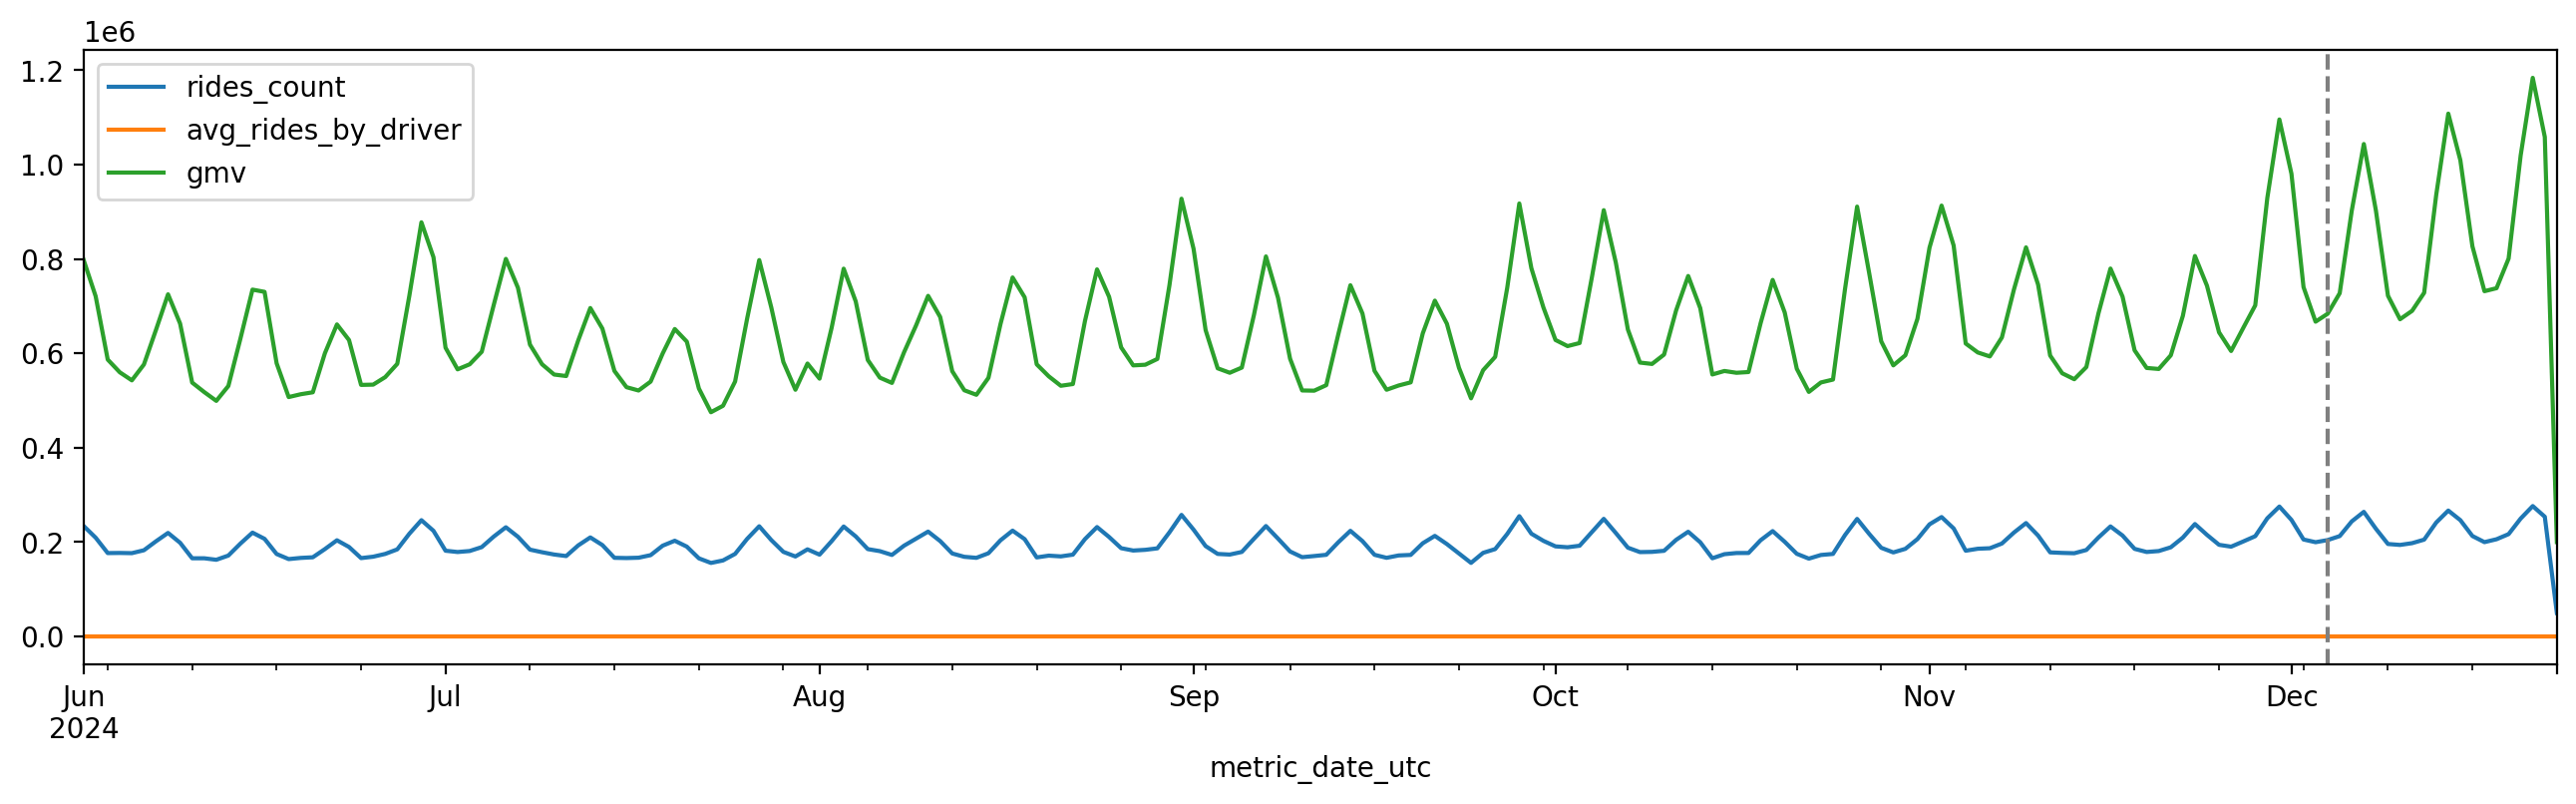

In [17]:
plt.figure(figsize = (16, 4))

df_result_causal_group['rides_count'].plot(label = 'rides_count')
df_result_causal_group['avg_rides_by_driver'].plot(label = 'avg_rides_by_driver')
df_result_causal_group['gmv'].plot(label = 'gmv')

plt.legend()
plt.axvline(x='2024-12-04',  color = 'grey', ls = '--')

<Axes: >

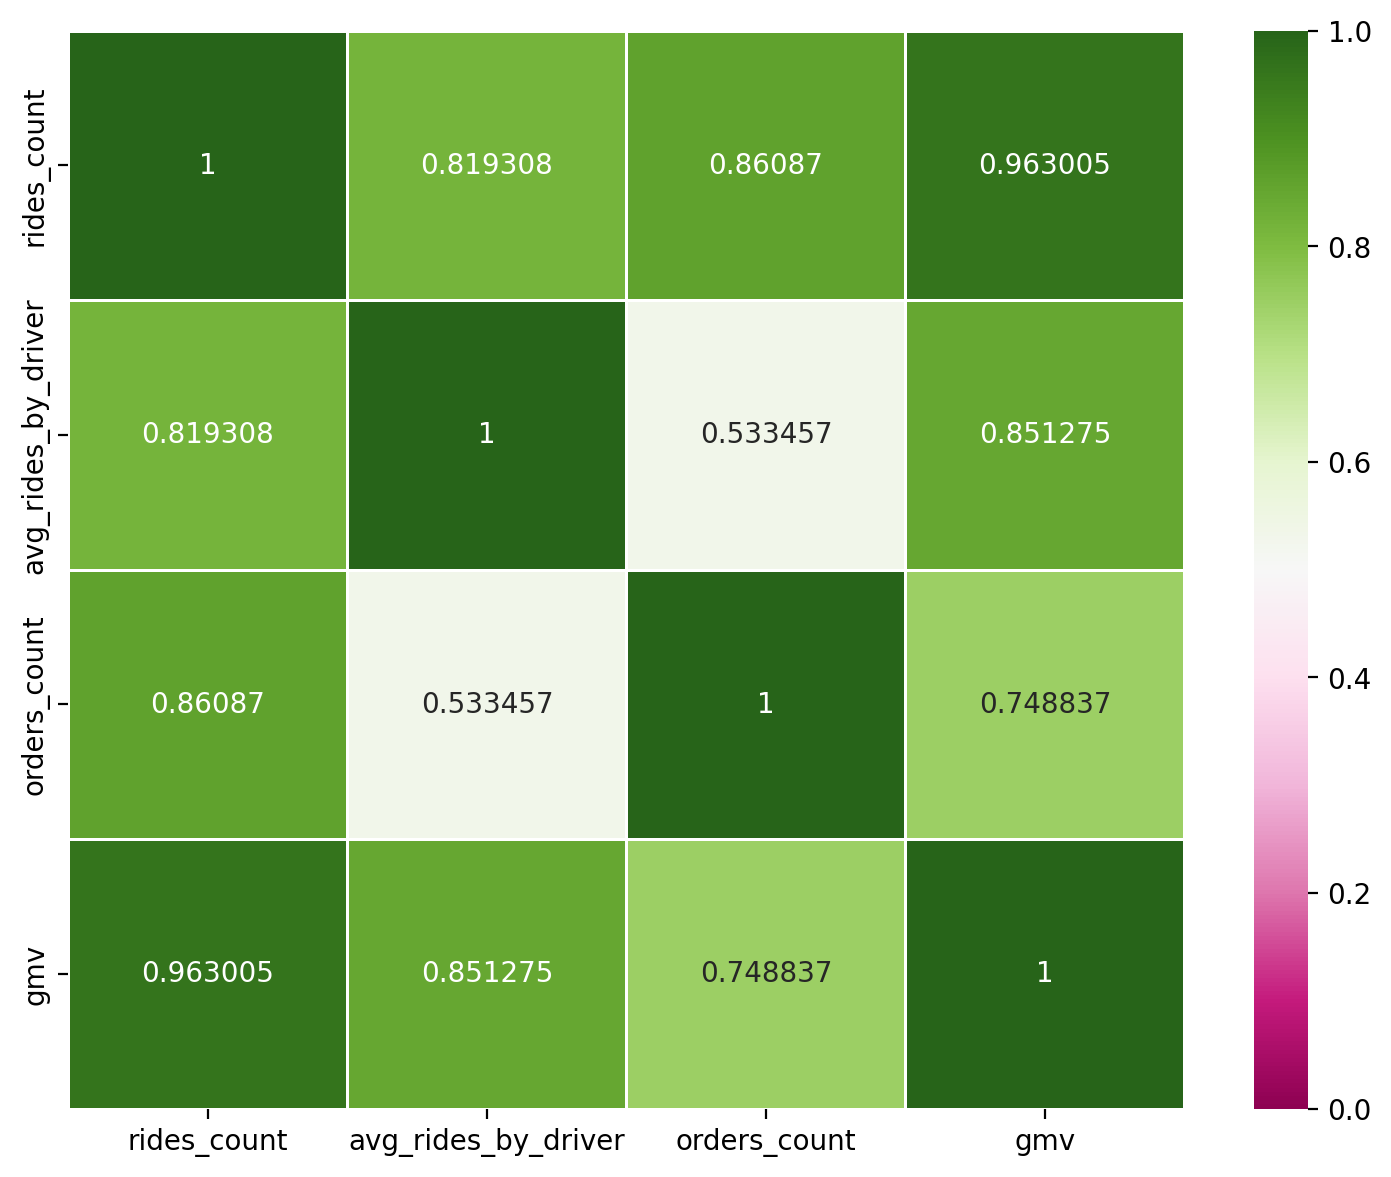

In [18]:
fig, ax = plt.subplots(figsize=(9,7)) 
sns.heatmap(df_result_causal_group.corr(), 
            annot=True,
            linewidth=1,
            cmap = "PiYG",
            vmin = 0, vmax = 1,
            square=False,
            annot_kws={"size": 10},
            fmt='g')


<Axes: xlabel='gmv', ylabel='rides_count'>

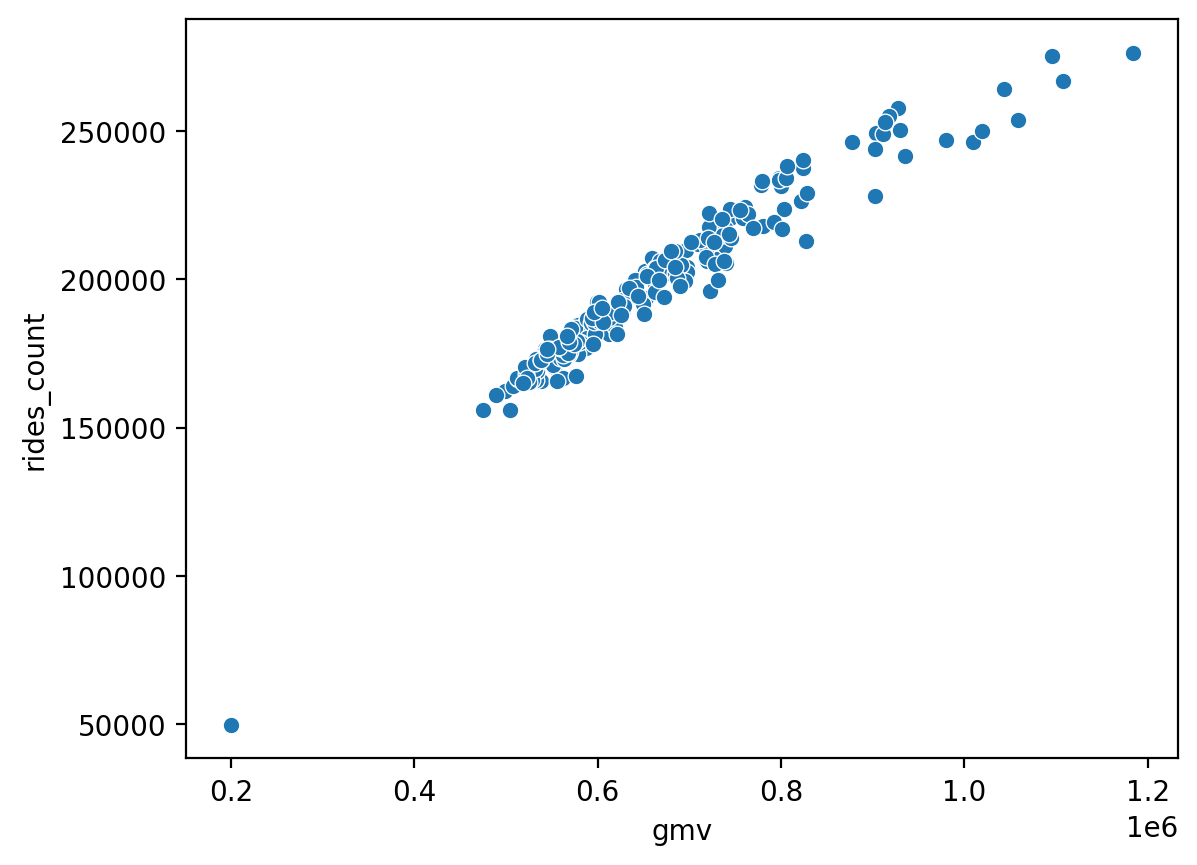

In [19]:
sns.scatterplot(x= df_result_causal_group.gmv, y = df_result_causal_group.rides_count)

In [20]:
ts_pre_period = [pd.to_datetime(date) for date in ["2024-06-01", "2024-12-03"]] 
ts_post_period = [pd.to_datetime(date) for date in ["2024-12-04", "2024-12-22"]] 


In [21]:
df_result_causal_group.head()

,rides_count,avg_rides_by_driver,orders_count,gmv
metric_date_utc,,,,
2024-06-01,234254,3.12,879756,"798,024.93"
2024-06-02,209333,3.13,801742,"720,844.19"
2024-06-03,176700,2.83,675773,"586,771.47"
2024-06-04,176964,2.75,685733,"559,762.40"
2024-06-05,176525,2.65,715167,"542,693.73"


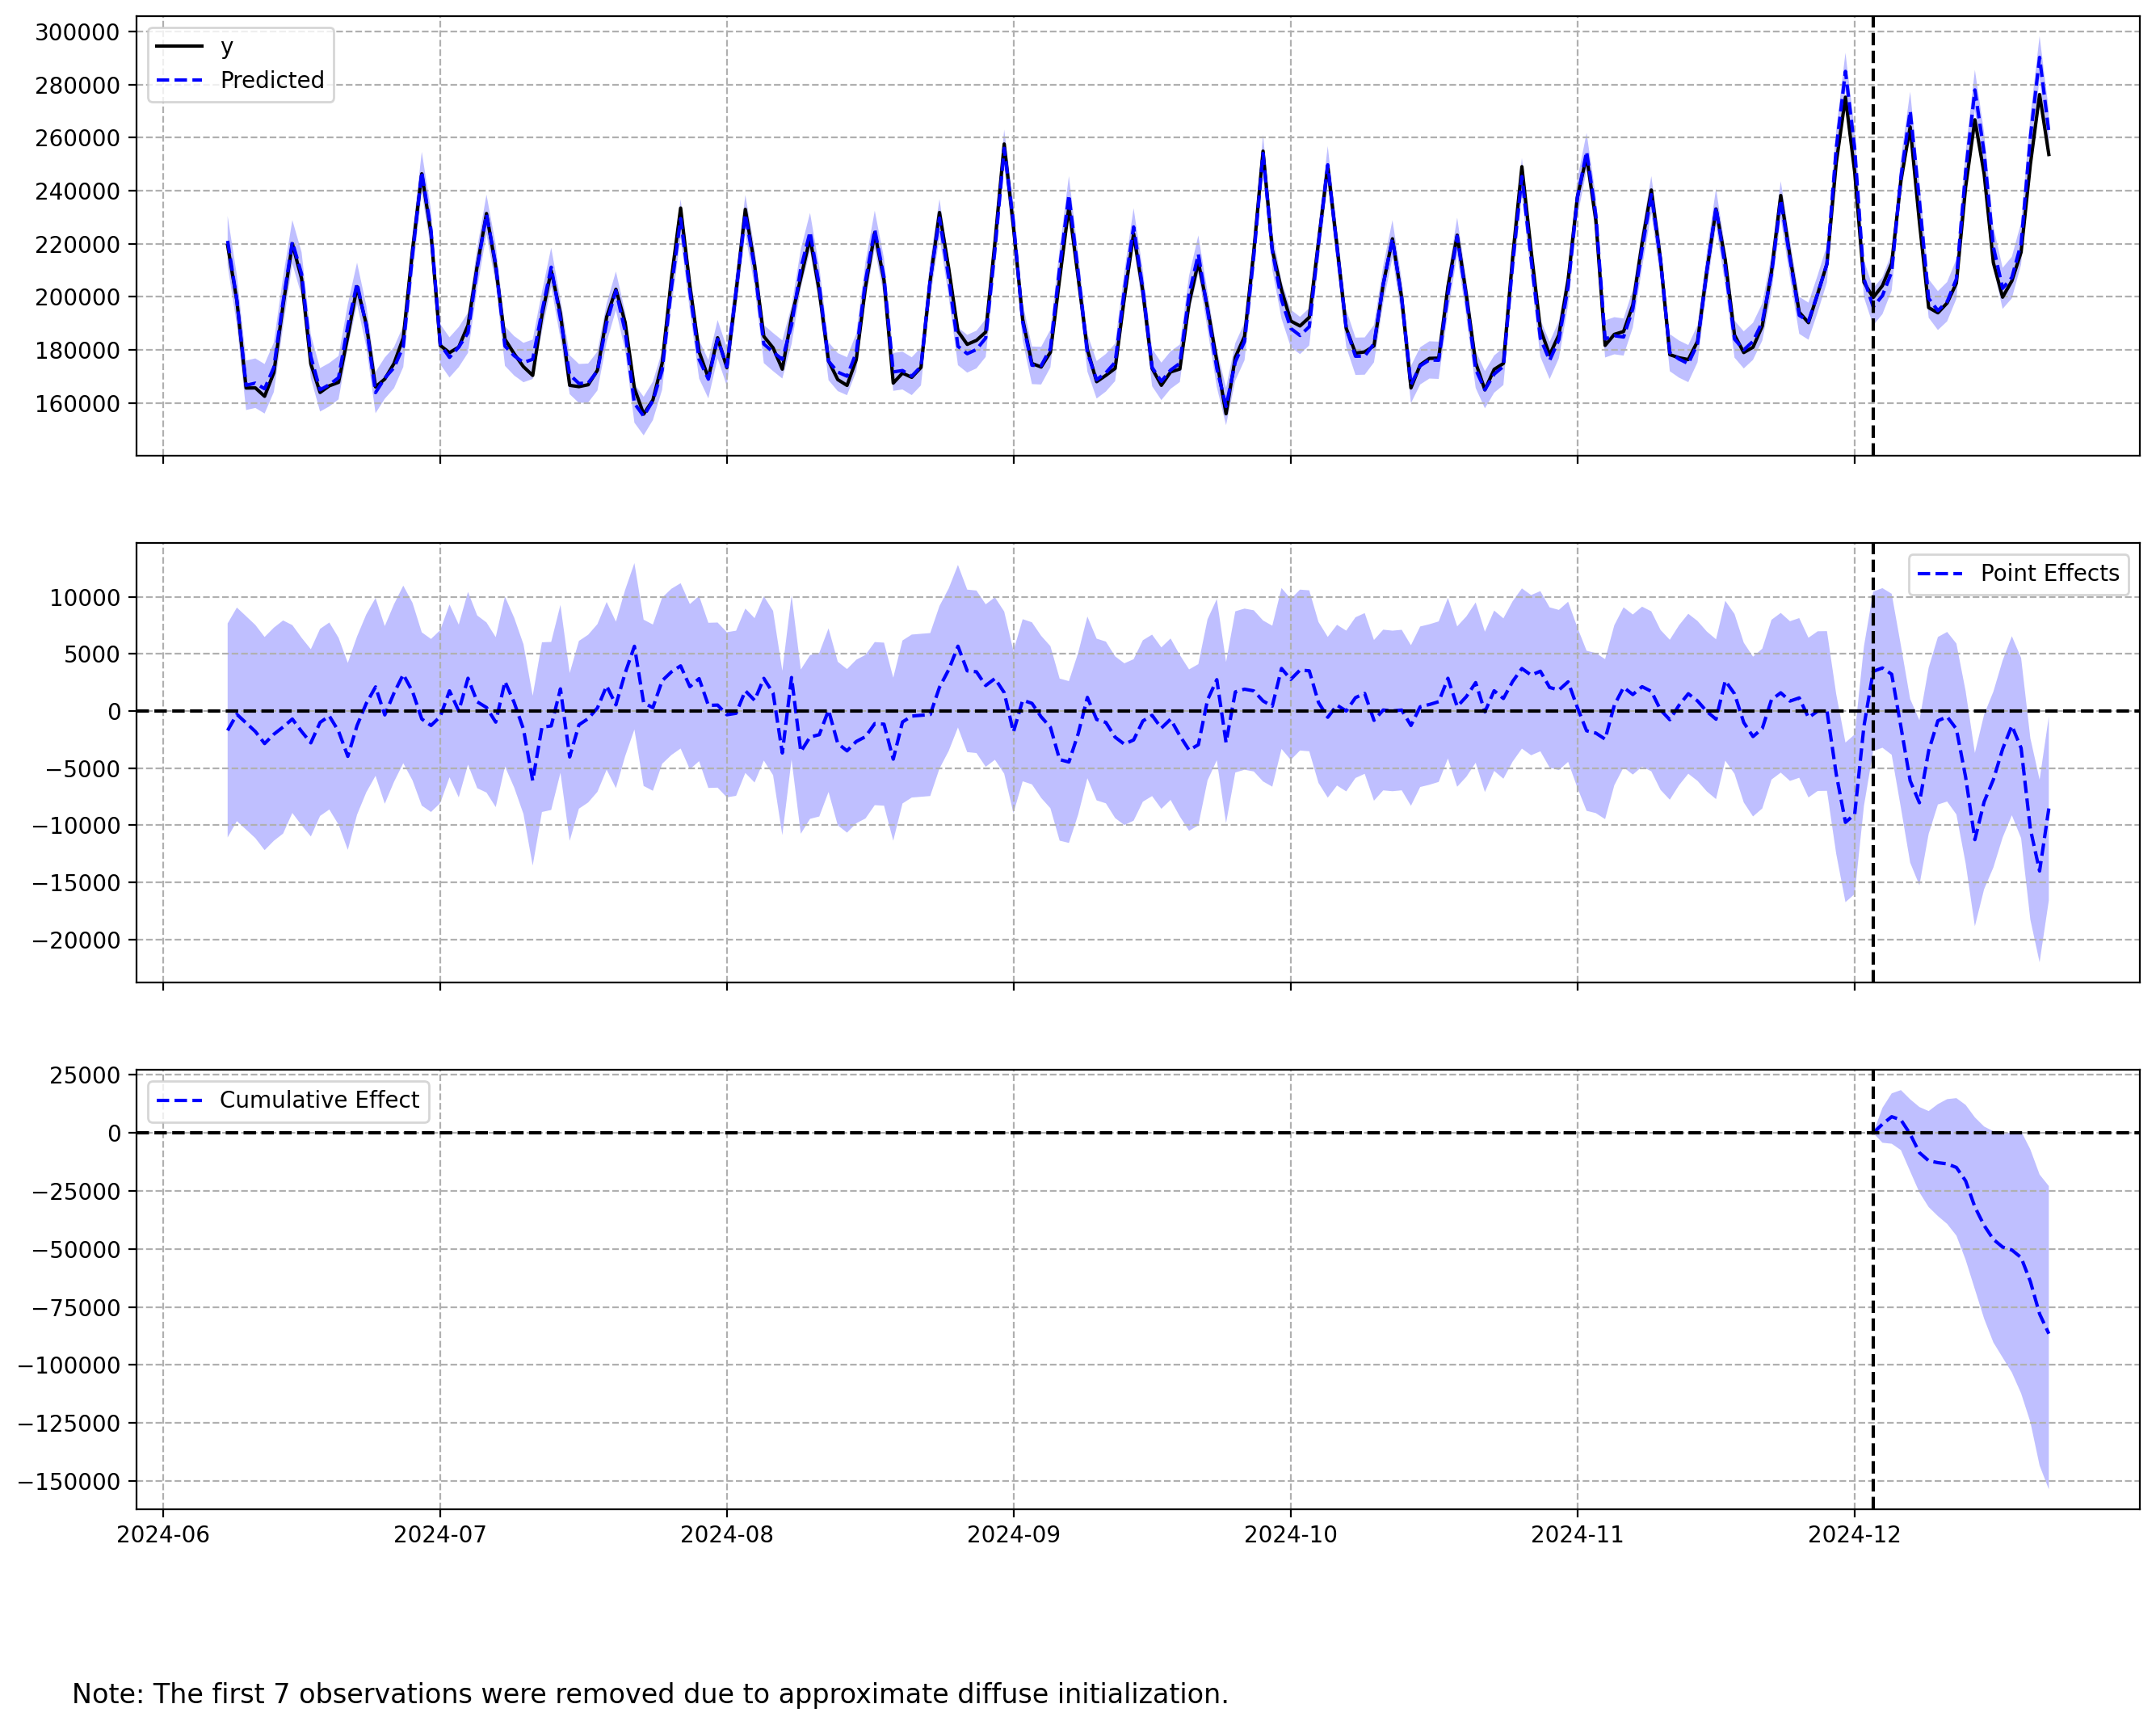

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    227146.95          4315792.0
Prediction (s.d.)         231699.89 (1045.0) 4402297.89 (19854.92)
99.9% CI                    [228351.24, 235228.41][4338673.5, 4469339.82]

Absolute effect (s.d.)    -4552.94 (1045.0)  -86505.89 (19854.92)
99.9% CI                    [-8081.46, -1204.29][-153547.82, -22881.5]

Relative effect (s.d.)    -1.97% (0.45%)     -1.97% (0.45%)
99.9% CI                    [-3.49%, -0.52%]   [-3.49%, -0.52%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


In [47]:
ci = CausalImpact(df_result_causal_group[['rides_count', 'avg_rides_by_driver', 'gmv', 'orders_count']].astype('float64'), ts_pre_period, ts_post_period, alpha = 0.001, nseasons=[{'period': 7}])
ci.plot(figsize = (16, 12))
print(ci.summary())

In [42]:
ci_data = ci.data.merge(ci.inferences, left_index = True, right_index = True)
ci_data_pre = ci_data.loc[ts_pre_period[0]:ts_pre_period[-1], :]

mae = mean_absolute_error(ci_data_pre.rides_count, ci_data_pre.preds)
mape = mean_absolute_percentage_error(ci_data_pre.rides_count, ci_data_pre.preds)
r2 = r2_score(ci_data_pre.rides_count, ci_data_pre.preds)

print('MAE =', round(mae, 3))
print('MAPE =', round(mape, 3))
print('R2_score =', r2)
print('Mean residuals =', ci_data_pre.point_effects.mean())


MAE = 1887.338
MAPE = 0.01
R2_score = 0.9896442923213136
Mean residuals = 77.82822136447551


p-value Dickey-Fuller = 0.000000
p-value Student test = 0.665614
p-value Ljung-Box test = 0.000000


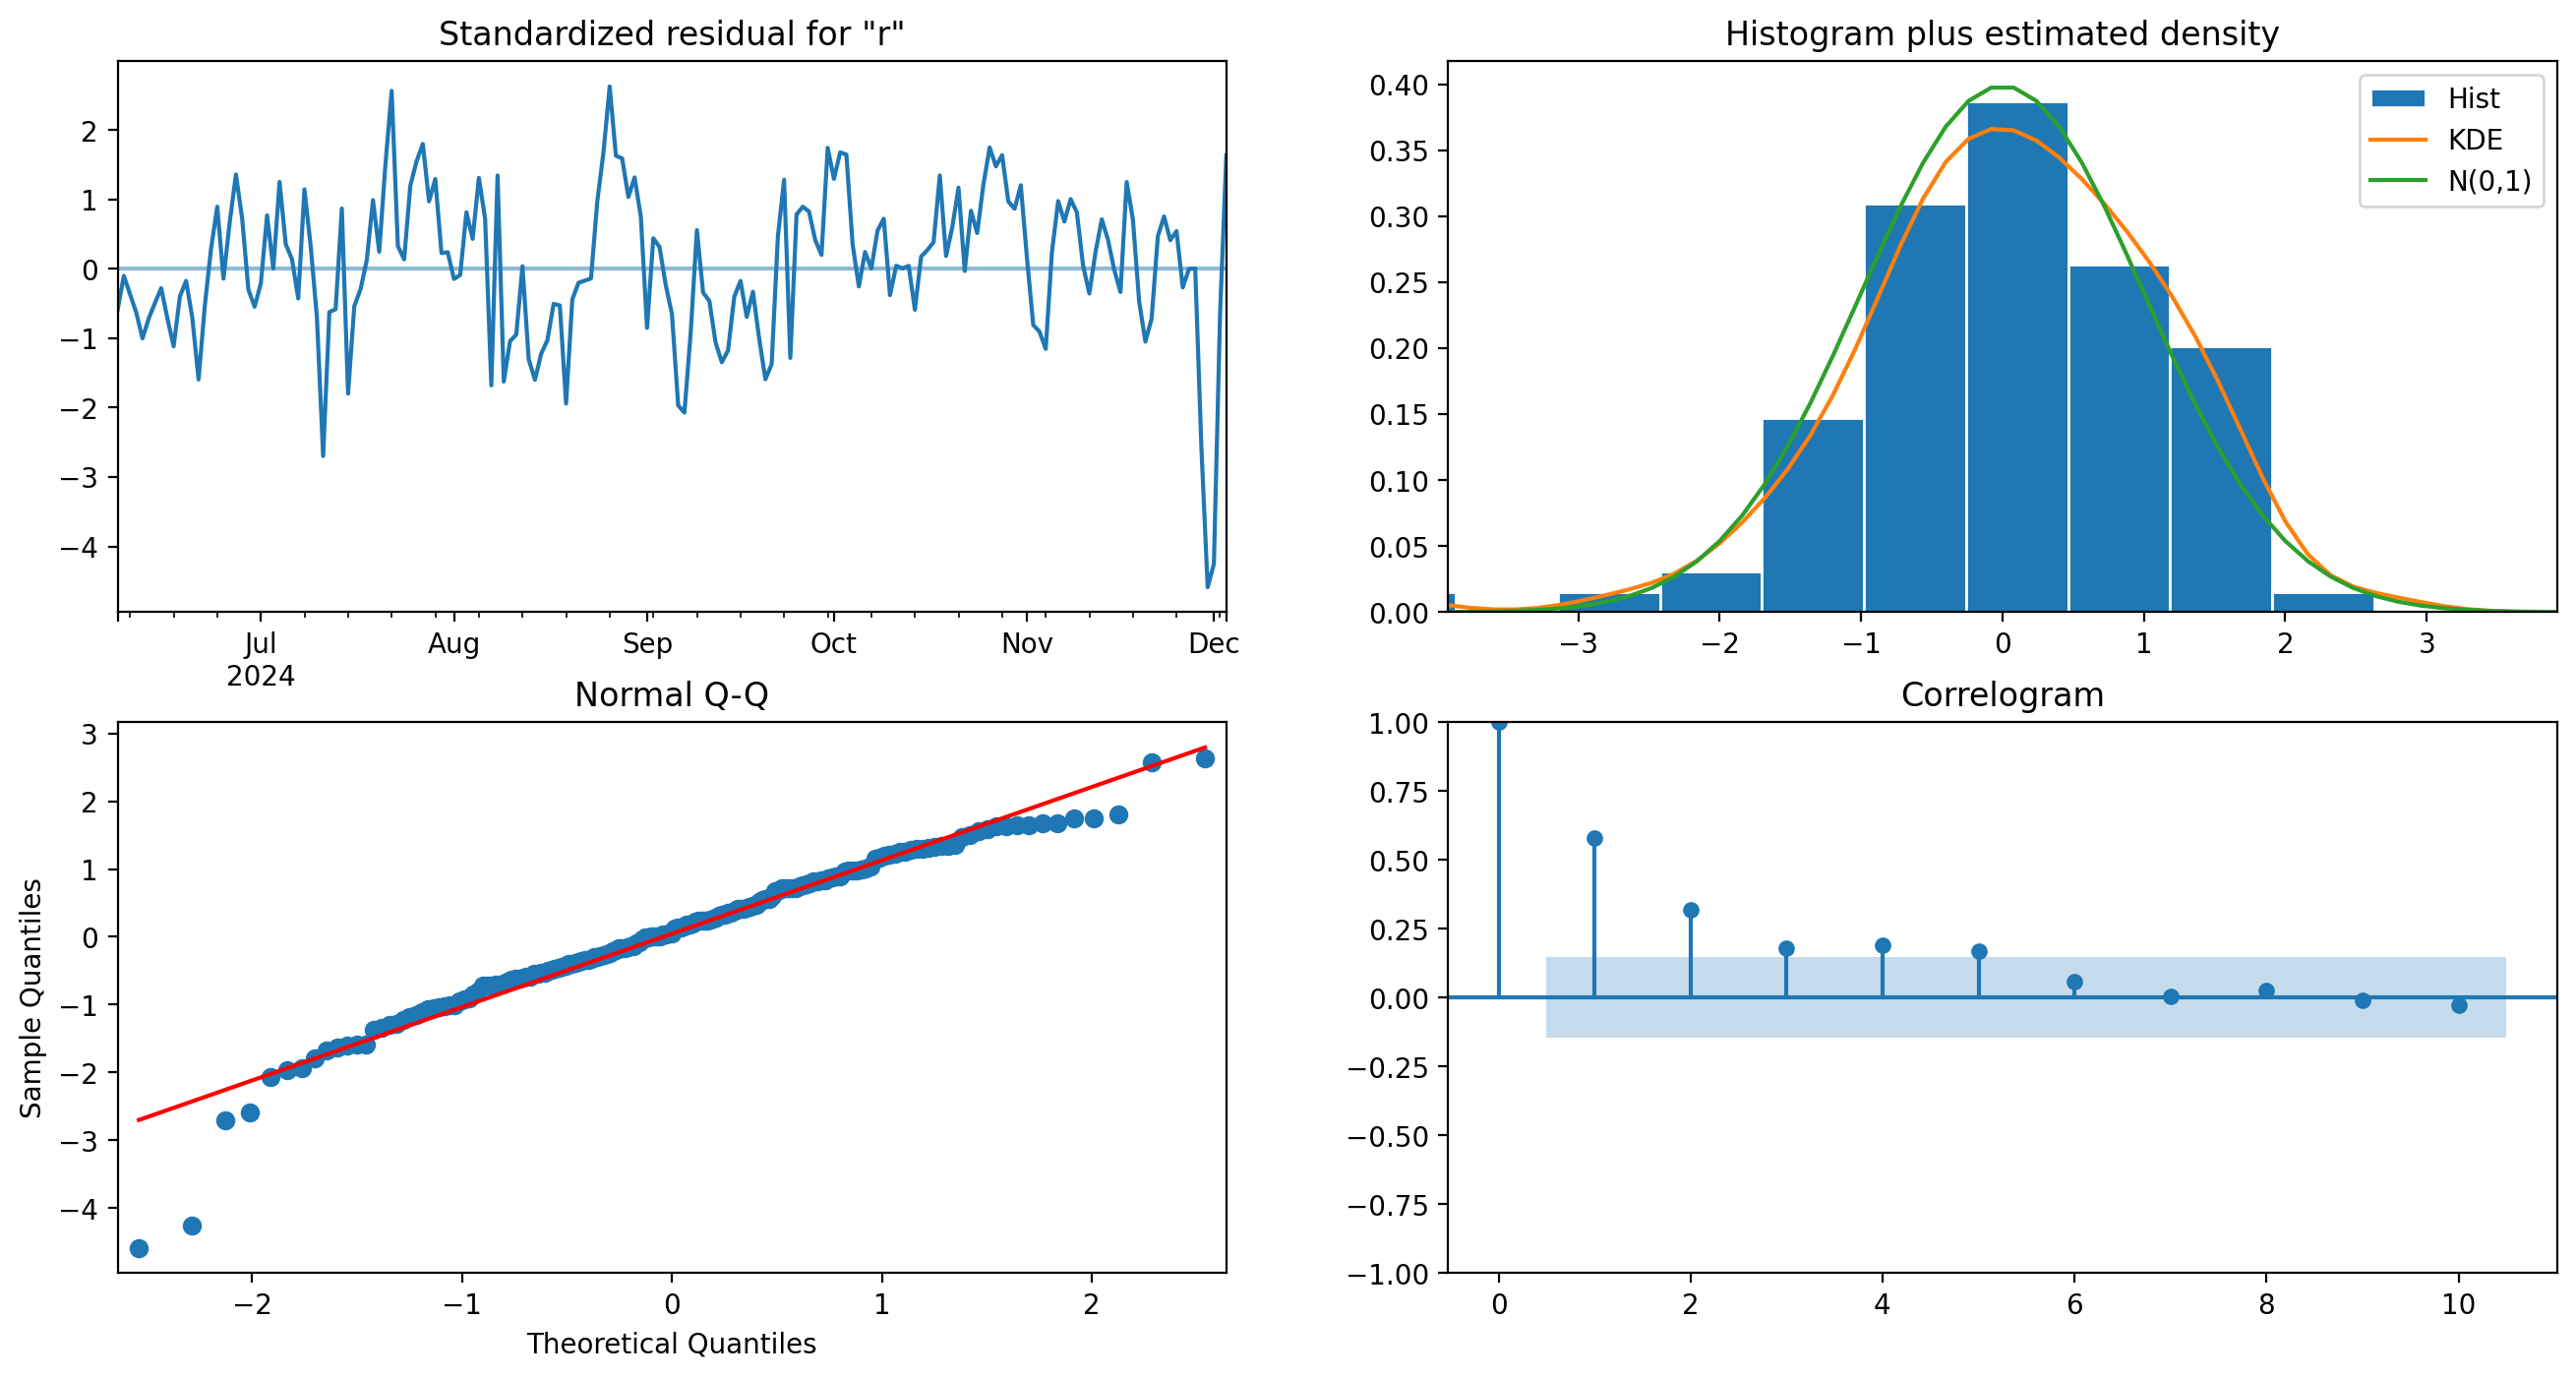

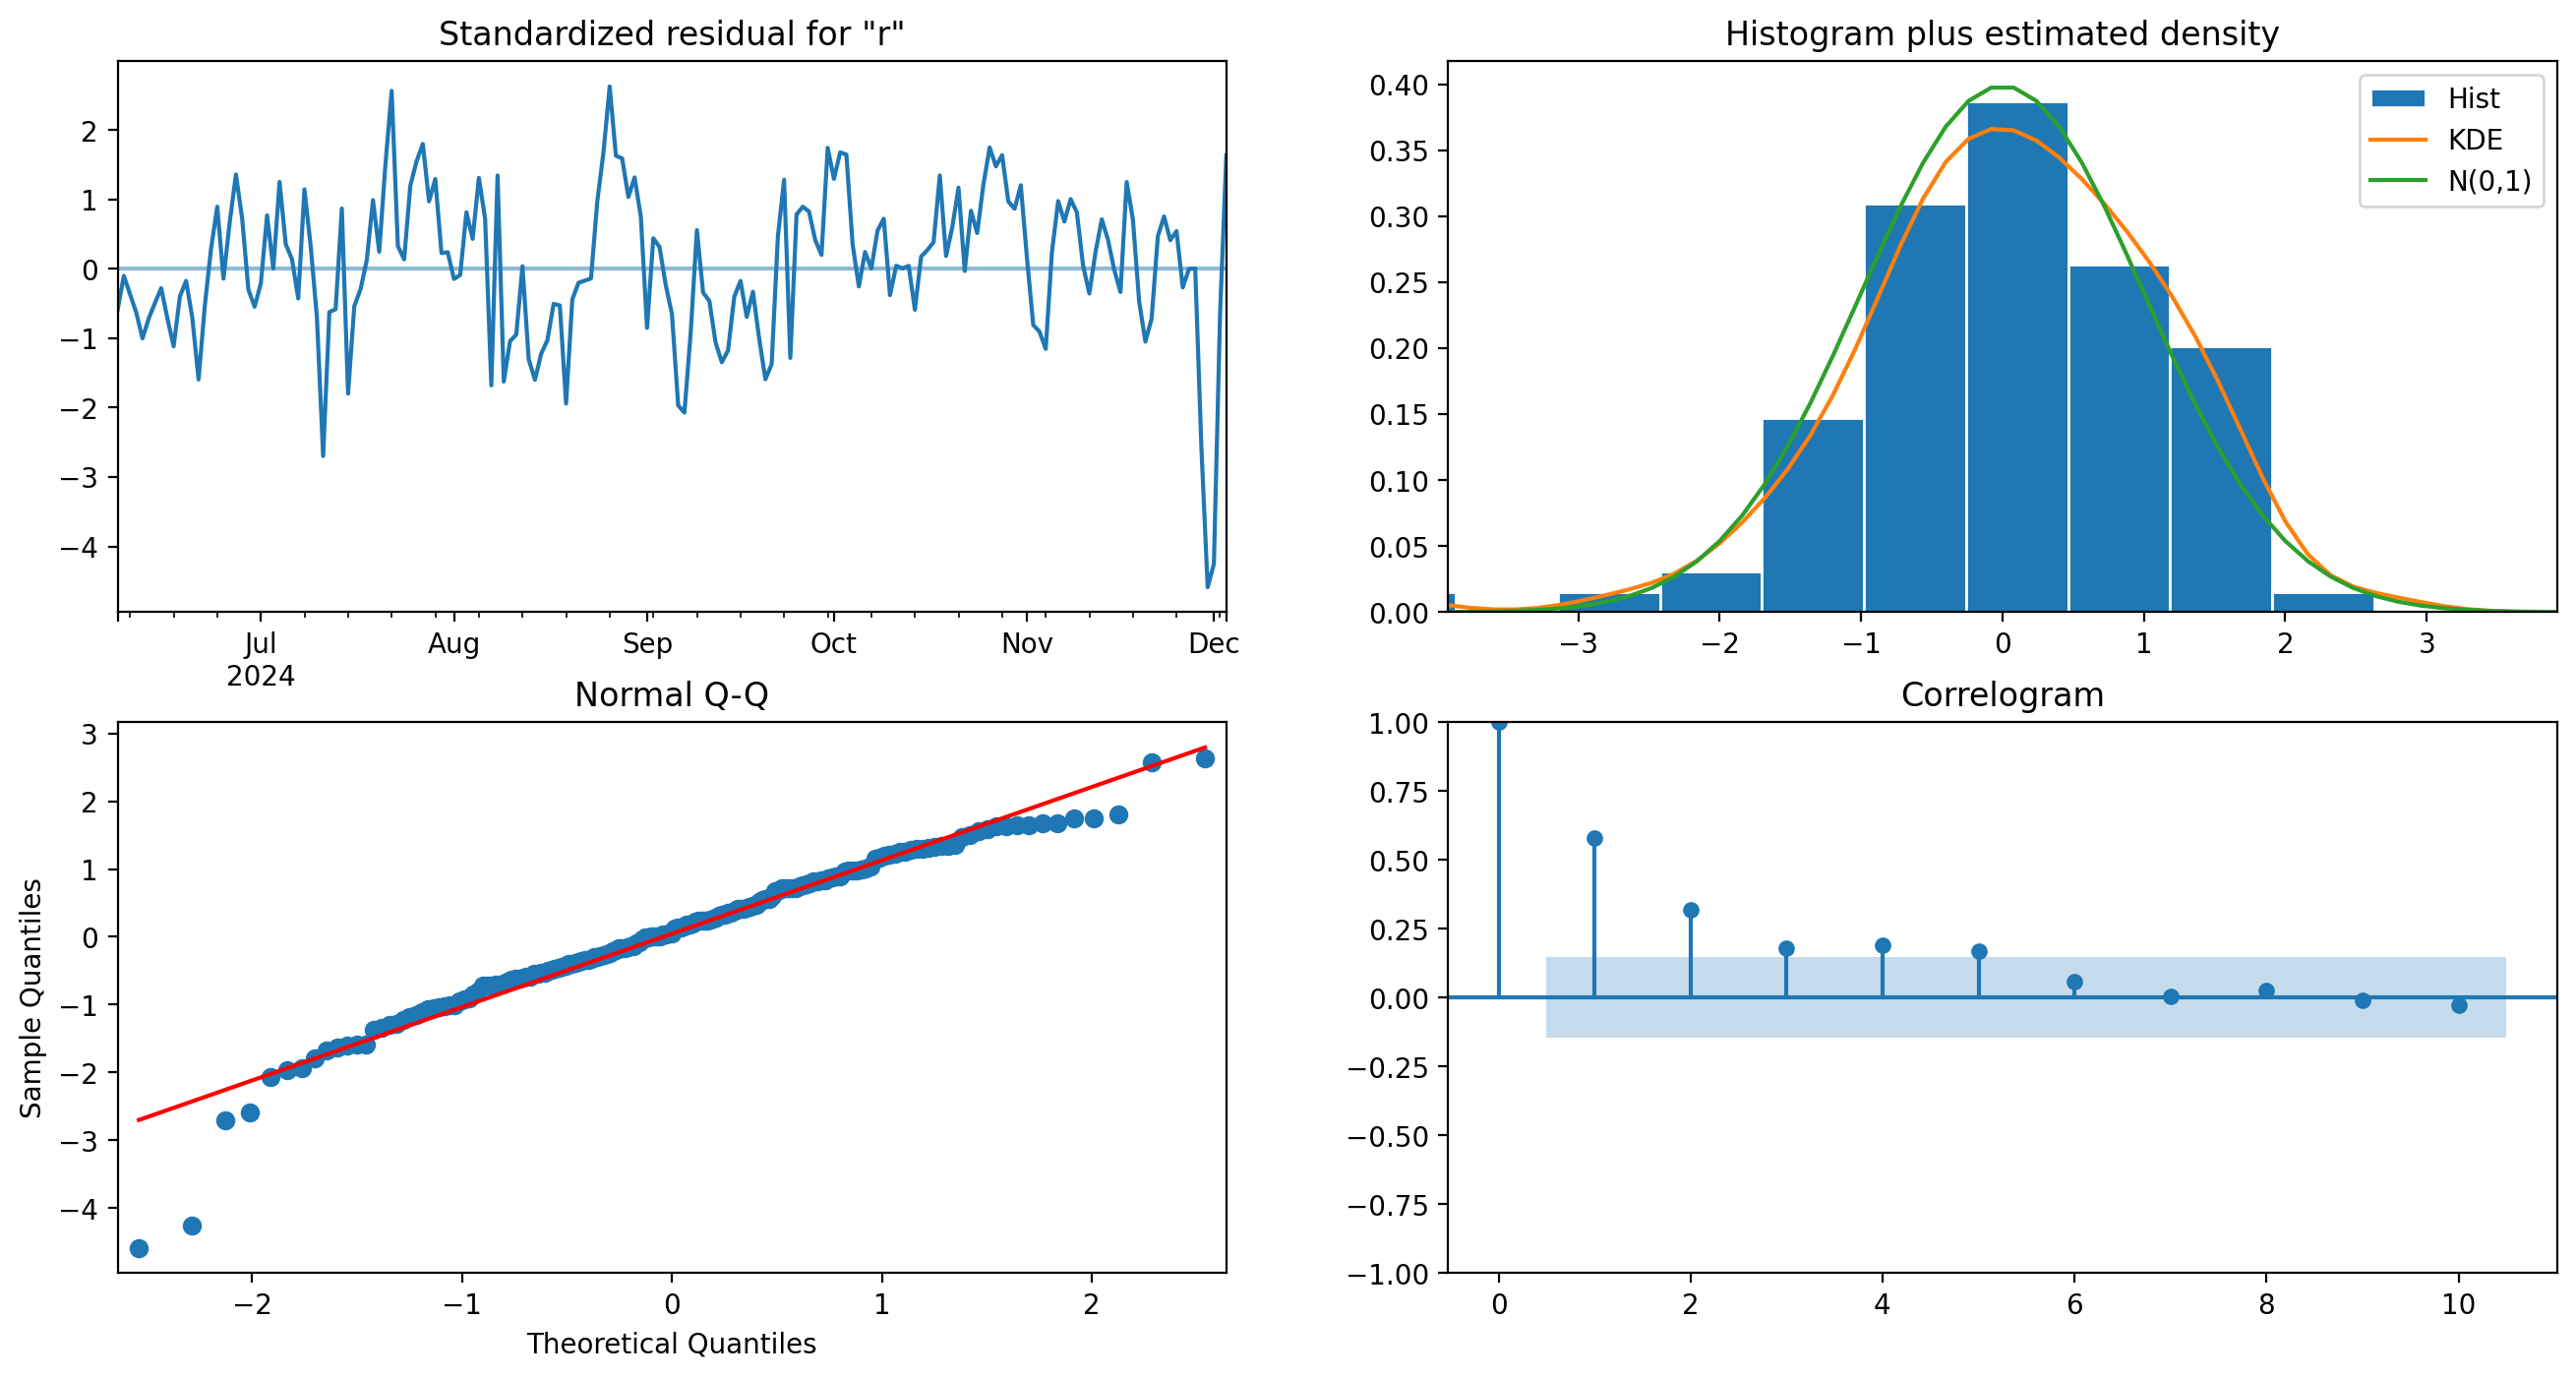

In [43]:
print("p-value Dickey-Fuller = %f" % sm.tsa.stattools.adfuller(ci.trained_model.resid)[1])
print("p-value Student test = %f" % ttest_1samp(ci.trained_model.resid, 0)[1])
print("p-value Ljung-Box test = %f" % ci.trained_model.test_serial_correlation('ljungbox')[0, :, 0][1])
ci.trained_model.plot_diagnostics(figsize = (16, 8))